# <ins>Modelling<ins>

# Problem Statement

Accurately predict the daily rainfall amount for  the city of Sydney

# Executive Summary

### Context


Human-caused climate change intensifies the heaviest downpours. More than 70% of the planet's surface is water, and as the world warms, more water evaporates from oceans, lakes, and soils. Every 1°F rise also allows the atmosphere to hold 4% more water vapor([source](https://www.climatecentral.org/news/report-pouring-it-on-climate-change-intensifies-heavy-rain-events#:~:text=Human%2Dcaused%20climate%20change%20intensifies,hold%204%25%20more%20water%20vapor.)).


As such the Department of Planning, Industry and Environment(DPIE) of New South Wales is particularly interested in Rainfall statistics, primarily Sydney, as it is one of the more densely populated cities within the state. Predicting the amount of Rainfall is imperative to the planning of the infrastructure of the city. Knowing and predicting Rainfall would aid in the prevention of flooding and the accumulation of stagnant waters. With this information, the DPIE will be able to gauge its drainage capacity and make better decisions.


### Scope

The objective of this project is to be able to predict daily Rainfall for the city of Sydney, to aid the DPIE of NSW to more accurately gauge their current position with Sydney's infrastructures and asssit in their future plans.

# Table of Contents

### Contents:
- Australia - ***1_AUS_Clean_EDA.ipynb***
    - Data Importing and Cleaning
        - Splitting by Cities
        - Exporting Cleaned Data
    - EDA
        - Distribution of Features
        - Correlation Heatmap
        - Pairplots
        - Bargraphs
- Sydney - ***2_Sydney_Clean_EDA_.ipynb***
   - Data Importing and Cleaning
   - EDA
        - Distribution of Features
        - Correlation Heatmap
        - Pairplots
        - Bargraphs
   - Exporting Cleaned Data
   - Modelling - ***3_Sydney_Modelling.ipynb***
     - [Time Series](#Time-Series)
        - [SARIMAX](#SARIMAX)
        - [fb Prophet](#fb-Prophet)
     - [Time Series Neural Network](#Time-Series-Neural-Network)
        - [Gated Recurrent Unit](#Gated-Recurrent-Unit)
   - [Conclusions and Recommendations](#Conclusions-and-Recommendations)

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import pmdarima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

from fbprophet import Prophet


%matplotlib inline

In [2]:
sydney = pd.read_csv('./datasets/cleaned_sydney.csv')

In [3]:
sydney.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindDir9am  \
0  2008-02-01     19.5     22.4      15.6          6.2       0.0          S   
1  2008-02-02     19.5     25.6       6.0          3.4       2.7          W   
2  2008-02-03     21.6     24.5       6.6          2.4       0.1        ESE   
3  2008-02-04     20.2     22.8      18.8          2.2       0.0        NNE   
4  2008-02-05     19.7     25.7      77.4          2.2       0.0        NNE   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        SSW          17.0          20.0         92.0         84.0   
1          E           9.0          13.0         83.0         73.0   
2        ESE          17.0           2.0         88.0         86.0   
3          E          22.0          20.0         83.0         90.0   
4          W          11.0           6.0         88.0         74.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  
0       1017.6       1017.4       8.0       8.0     20.7     20.9  
1       1017.9       1016.4       7.0       7.0     22.4     24.8  
2       1016.7       1015.6       7.0       8.0     23.5     23.0  
3       1014.2       1011.8       8.0       8.0     21.4     20.9  
4       1008.3       1004.8       8.0       8.0     22.5     25.5

In [4]:
#changing our date to datetime(this gets lost when converted to csv and read again)
sydney['Date'] = pd.to_datetime(sydney['Date'])

In [5]:
sydney.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindDir9am  \
0 2008-02-01     19.5     22.4      15.6          6.2       0.0          S   
1 2008-02-02     19.5     25.6       6.0          3.4       2.7          W   
2 2008-02-03     21.6     24.5       6.6          2.4       0.1        ESE   
3 2008-02-04     20.2     22.8      18.8          2.2       0.0        NNE   
4 2008-02-05     19.7     25.7      77.4          2.2       0.0        NNE   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        SSW          17.0          20.0         92.0         84.0   
1          E           9.0          13.0         83.0         73.0   
2        ESE          17.0           2.0         88.0         86.0   
3          E          22.0          20.0         83.0         90.0   
4          W          11.0           6.0         88.0         74.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  
0       1017.6       1017.4       8.0       8.0     20.7     20.9  
1       1017.9       1016.4       7.0       7.0     22.4     24.8  
2       1016.7       1015.6       7.0       8.0     23.5     23.0  
3       1014.2       1011.8       8.0       8.0     21.4     20.9  
4       1008.3       1004.8       8.0       8.0     22.5     25.5

In [6]:
## convert our wind directions into angles based on the Azimuth Angles and Bearings
#this reduces the number of features vs if we had one hot encoded these 2 columns
sydney['WindDir9am'] = sydney['WindDir9am'].map({'N': 0,
                                             'NNE': 22.5,
                                             'NE': 45,
                                             'ENE': 67.5,
                                             'E': 90,
                                             'ESE':110.5,
                                             'SE':135,
                                             'SSE':157.5,
                                             'S':180,
                                             'SSW':202.5,
                                             'SW':225,
                                             'WSW':247.5,
                                             'W':270,
                                             'WNW':292.5,
                                             'NW':315,
                                             'NNW':337.5
                                            })
sydney['WindDir3pm'] = sydney['WindDir3pm'].map({'N': 0,
                                             'NNE': 22.5,
                                             'NE': 45,
                                             'ENE': 67.5,
                                             'E': 90,
                                             'ESE':110.5,
                                             'SE':135,
                                             'SSE':157.5,
                                             'S':180,
                                             'SSW':202.5,
                                             'SW':225,
                                             'WSW':247.5,
                                             'W':270,
                                             'WNW':292.5,
                                             'NW':315,
                                             'NNW':337.5
                                            })

In [7]:
sydney.shape

(3337, 18)

# Time Series

We cannot discount the time factor when it comes to making predictions with rain as the condition/state of the previous day or even further back will most definitely influence the rain today.  
As such, here we will be incorporating the time factor to all of our models.

In [8]:
# Reset index to be date.
# Frequency has to be stated here as it is a required variable in the modelling segment
#(even though our data is already a set of daily observations)
sydney.index = pd.date_range(start = '02/01/2008',
                                periods = len(sydney['Date']),
                                freq = 'D')

# Drop date column.
sydney.drop(columns = 'Date', inplace = True)

# Print shape of dataframe.
print(sydney.shape)

# Check head of dataframe.
sydney.head()

(3337, 17)


MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindDir9am  \
2008-02-01     19.5     22.4      15.6          6.2       0.0       180.0   
2008-02-02     19.5     25.6       6.0          3.4       2.7       270.0   
2008-02-03     21.6     24.5       6.6          2.4       0.1       110.5   
2008-02-04     20.2     22.8      18.8          2.2       0.0        22.5   
2008-02-05     19.7     25.7      77.4          2.2       0.0        22.5   

            WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
2008-02-01       202.5          17.0          20.0         92.0         84.0   
2008-02-02        90.0           9.0          13.0         83.0         73.0   
2008-02-03       110.5          17.0           2.0         88.0         86.0   
2008-02-04        90.0          22.0          20.0         83.0         90.0   
2008-02-05       270.0          11.0           6.0         88.0         74.0   

            Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  
2008-02-01       1017.6       1017.4       8.0       8.0     20.7     20.9  
2008-02-02       1017.9       1016.4       7.0       7.0     22.4     24.8  
2008-02-03       1016.7       1015.6       7.0       8.0     23.5     23.0  
2008-02-04       1014.2       1011.8       8.0       8.0     21.4     20.9  
2008-02-05       1008.3       1004.8       8.0       8.0     22.5     25.5

In [9]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(15,5))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=14, rotation=90);

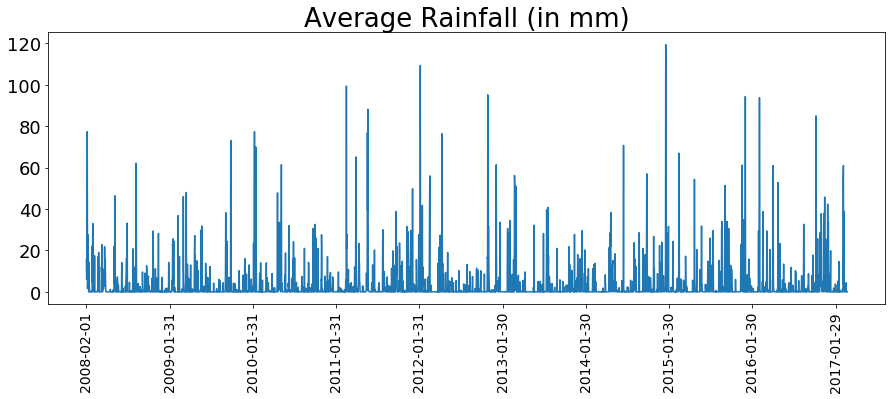

In [10]:
plot_series(sydney, ['Rainfall'], title = "Average Rainfall (in mm)", steps=365)

Here we will be looking at Rainfall with respect to time, above is the plot of every Rainfall observation in our dataset.

In [11]:
#Using the first 4/5th of our dataset to be the train dataset.
#We wont be using train test split as we won't be using other features except time and time is sequential.
sydney.shape[0] * (4 / 5)

2669.6000000000004

In [12]:
#using the remaining fifth as the test dataset.
sydney.shape[0] * (1 / 5)

667.4000000000001

In [13]:
sydney.shape

(3337, 17)

In [14]:
#assigning our train and test
traind = sydney.iloc[0:2669]
testd = sydney.iloc[2669:]

In [15]:
testd.shape

(668, 17)

The Dickey-Fuller test determines the test statistic and p-value of our dataset.  
The time series requires the data to be stationary.  
If the p-value is too large, we may want to consider differencing our data as the time series requires stationarity.

In [16]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(traind['Rainfall']))

Test Statistic   -36.572219
p-value            0.000000
dtype: float64

Here our p-value is so small that it is practically 0 and as such considered stationary.

When it comes to time series, we also want to see if there is any seasonality within our data itself.  
Here we use a statsmodel seasonal decompose to analyse the seasonality of our data.  
We have scoped down to the latest year in our training data set to view this.

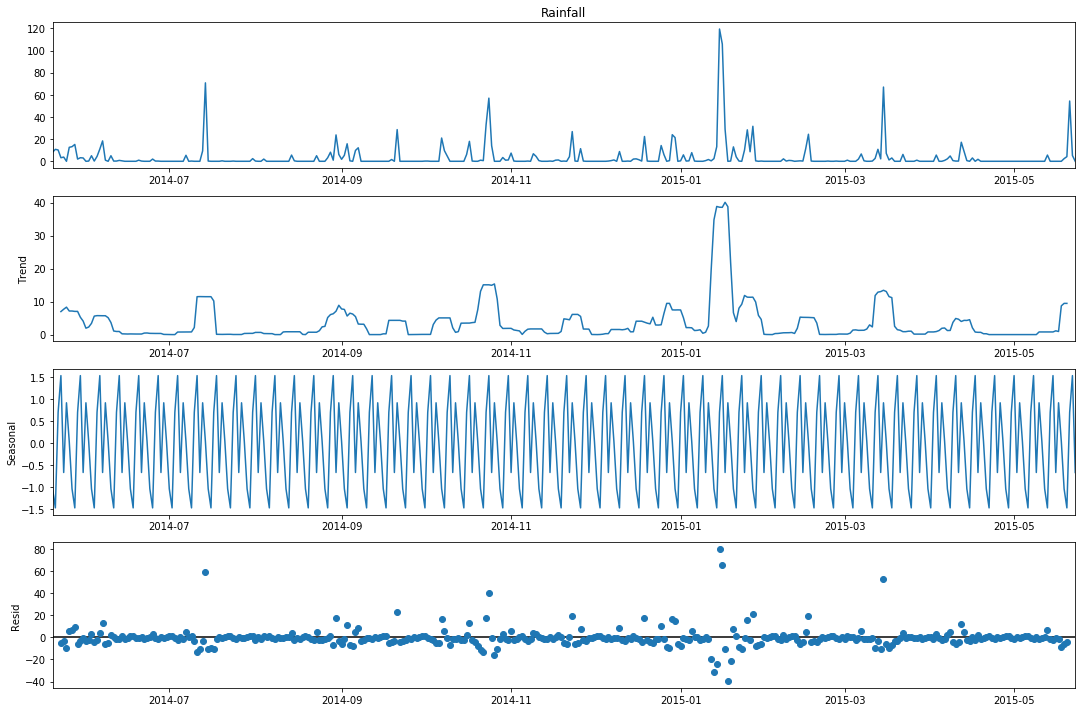

In [17]:
with plt.rc_context():
    plt.rc("figure", figsize=(15,10)) # allows resizing of the statsmodel figure
    sm.tsa.seasonal_decompose(traind.Rainfall[2300:]).plot()
    result = sm.tsa.stattools.adfuller(traind.Rainfall[2300:])
    #plt.savefig('./images/syd_seasonality.png', bbox_inches='tight')
    plt.show()

As can be observed by the above plot, there is a form of seasonality that happens every 7 observations aka, weekly seasonality. This seasonality will be utilised in our time series modelling.

## SARIMAX

### using Auto ARIMA

In [18]:
exo= traind.columns.tolist()
exo.remove('Rainfall')

In [ ]:
pmdarima.arima.auto_arima(traind['Rainfall'],
                          max_p=5,
                          max_q=5,
                          m=52,
                          d=0,
                          D=None,
                          start_Q=0,
                          max_Q=3,
                          start_P=0,
                          max_P=3,                        
                          trace=True,
                          error_action='ignore',
                          suppress_warning=True,
                          stepwise=True,
                          seasonal=True,
                          max_iter = 50,
                          exogenous = traind[exo]
                          )

The auto arima function in pmdarima allwos us to 'gridsearch' our p, d, q and our P, D, Q values with the metric being AIC, a statistical metric to measure the 'fit' of the model.

In this case, it has returned (1,0,0) x (0,0,0,52) as our best hyper parameters.

The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:

7 - daily  
12 - monthly  
52 - weekly  

(source:https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period)

In [19]:
sydney.shape

(3337, 17)

In [20]:
traind.shape

(2669, 17)

In [21]:
testd.shape

(668, 17)

In [22]:
# Fitting the recommended SARIMAX(1, 0, 0) x (0, 0, 0, 52) model.

sarima = SARIMAX(endog = traind['Rainfall'],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 52) # (P, D, Q, S)
                 ,exog= traind[exo]
                 , freq= 'D'
                ) 


# Fit SARIMAX model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=2669, end=3336, exog= testd[exo])

# Evaluate predictions.
mean_squared_error(testd['Rainfall'], preds)

C:\Users\fadhil\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


102.06568021657063

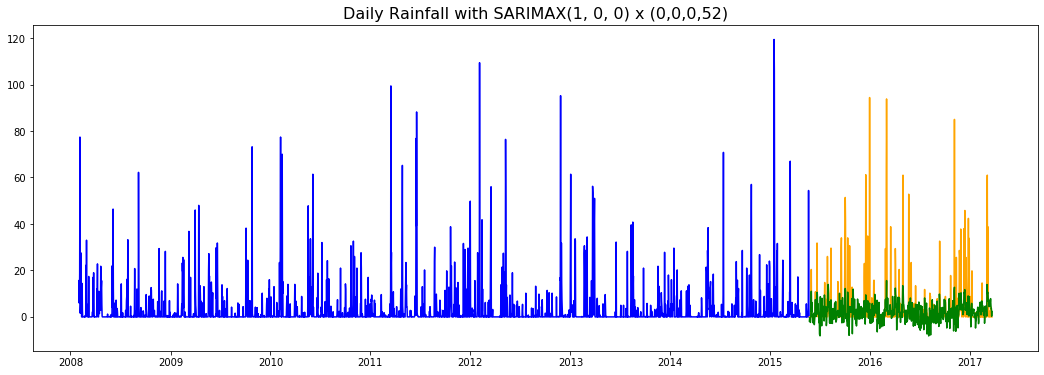

In [23]:
plt.figure(figsize=(18,6))
plt.plot(traind['Rainfall'], color = 'blue')
plt.plot(testd['Rainfall'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Daily Rainfall with SARIMAX(1, 0, 0) x (0,0,0,52)', fontsize=16)
#plt.savefig('./images/SARIMAX_neg.png', bbox_inches='tight')
plt.show();

From the above, our SARIMAX model seems to have done quite well, our fluctuaions do seem similar in patter. However it was unable to match the magnitude of the sudden spikes in amplitudes. Also, the SARIMAX predictions produced negative values which we should convert to zero as the is no such thing as negative rainfall.

In [24]:
preds[preds<0]=0

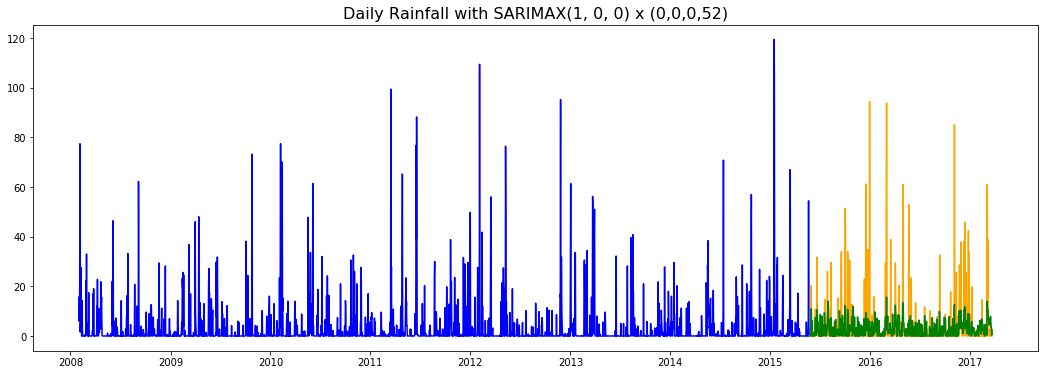

In [25]:
plt.figure(figsize=(18,6))
plt.plot(traind['Rainfall'], color = 'blue')
plt.plot(testd['Rainfall'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Daily Rainfall with SARIMAX(1, 0, 0) x (0,0,0,52)', fontsize=16)
#plt.savefig('./images/SARIMAX.png', bbox_inches='tight')
plt.show();

In [26]:
mean_squared_error(testd['Rainfall'], preds)

99.07053274478336

# fb Prophet

Facebook has created Prophet for easier prediction making and specifically in this case, not confined to seasonality within a year, unlike our SARIMAX time series counterpart.

Yearly seasonality that we previously could not account for with SARIMAX can be resolved by Prophet.

In [27]:
sydney_prophet = sydney.copy()

In [28]:
#Prophet requires a date column and a target variable column as its inputs.
sydney_prophet.reset_index(inplace=True)

In [29]:
sydney_prophet.columns

Index(['index', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')

In [30]:
sydney_prophet.columns=['ds', 'MinTemp', 'MaxTemp', 'y', 'Evaporation', 'Sunshine',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm']

In [31]:
train = sydney_prophet[:2669]

In [32]:
train.columns

Index(['ds', 'MinTemp', 'MaxTemp', 'y', 'Evaporation', 'Sunshine',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')

In [33]:
#Prophet will auto detect the seasonality
m = Prophet(yearly_seasonality=10) #the value here suggests the resolution of our seasonality when considering yearly


In [34]:
m.add_regressor('MinTemp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('MaxTemp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Evaporation', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Sunshine', prior_scale=0.5, mode='multiplicative')
m.add_regressor('WindDir9am', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Humidity3pm', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Pressure9am', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Pressure3pm', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Cloud9am', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Temp9am', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Evaporation', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Temp3pm', prior_scale=0.5, mode='multiplicative')
m.add_regressor('WindDir9am', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Humidity3pm', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Pressure9am', prior_scale=0.5, mode='multiplicative')

In [35]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
forecast = m.predict(sydney_prophet)
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail() #also shows the error margin of the predictions

ds       yhat  yhat_lower  yhat_upper
3332 2017-03-17   7.743143   -3.066727   18.466568
3333 2017-03-18   5.036581   -6.064956   16.399467
3334 2017-03-19  10.186229   -0.911143   21.286990
3335 2017-03-20   4.921068   -6.130947   16.902308
3336 2017-03-21   2.346157   -8.204113   14.290138

Below, we have a plot of our model trend that was learnt, extrapolation of our predictions and the observations our mdoeal was trained on.

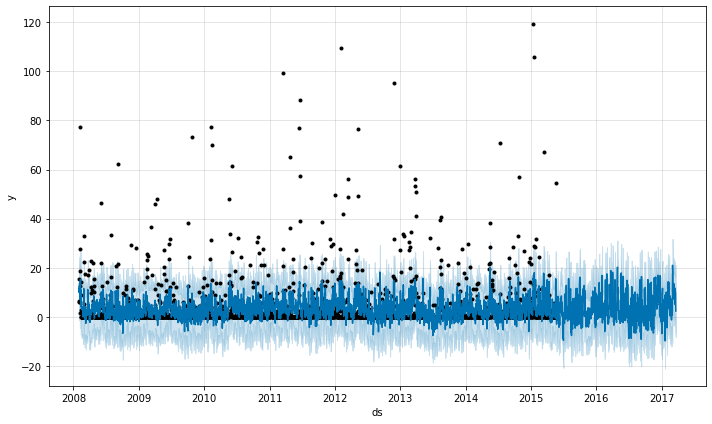

In [37]:
fig1 = m.plot(forecast)

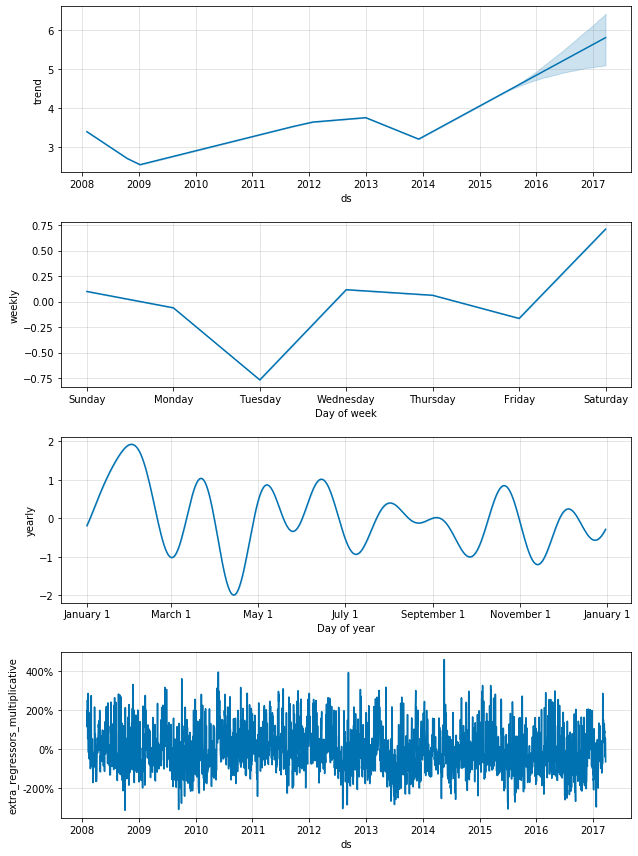

In [38]:
fig2 = m.plot_components(forecast)
#plt.savefig('./images/fb_components.png', bbox_inches='tight')

The yearly seasonality thought we saw is untrue according to this seasonality plot.  
There are variaitons within the year, but no clear period or oscillation between the years themselves.

In [39]:
#interactive plotly graph for our model
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)
py.iplot(fig)

In [40]:
forecast.set_index('ds', inplace=True)
sydney_prophet.set_index('ds', inplace=True)

In [41]:
forecast[forecast['yhat']<0]=0

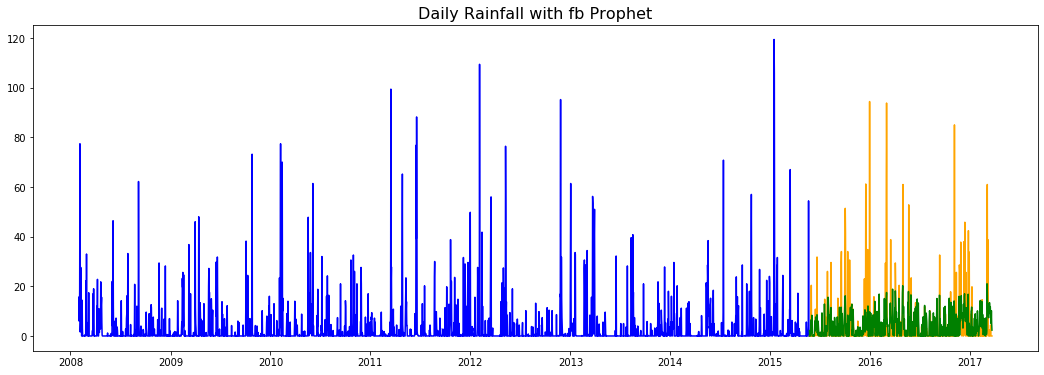

In [42]:
plt.figure(figsize=(18,6))
plt.plot(sydney_prophet['y'][:2669], color = 'blue')
plt.plot(sydney_prophet['y'][2669:], color = 'orange')
plt.plot(forecast['yhat'][2669:], color = 'green')
plt.title(label = 'Daily Rainfall with fb Prophet', fontsize=16)
plt.savefig('./images/prophet.png', bbox_inches='tight')
plt.show();

In [43]:
mean_squared_error(sydney_prophet['y'][2669:],forecast['yhat'][2669:])

104.26239791761367

# Time Series Neural Network

In [44]:
sydney.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindDir9am  \
2008-02-01     19.5     22.4      15.6          6.2       0.0       180.0   
2008-02-02     19.5     25.6       6.0          3.4       2.7       270.0   
2008-02-03     21.6     24.5       6.6          2.4       0.1       110.5   
2008-02-04     20.2     22.8      18.8          2.2       0.0        22.5   
2008-02-05     19.7     25.7      77.4          2.2       0.0        22.5   

            WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
2008-02-01       202.5          17.0          20.0         92.0         84.0   
2008-02-02        90.0           9.0          13.0         83.0         73.0   
2008-02-03       110.5          17.0           2.0         88.0         86.0   
2008-02-04        90.0          22.0          20.0         83.0         90.0   
2008-02-05       270.0          11.0           6.0         88.0         74.0   

            Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  
2008-02-01       1017.6       1017.4       8.0       8.0     20.7     20.9  
2008-02-02       1017.9       1016.4       7.0       7.0     22.4     24.8  
2008-02-03       1016.7       1015.6       7.0       8.0     23.5     23.0  
2008-02-04       1014.2       1011.8       8.0       8.0     21.4     20.9  
2008-02-05       1008.3       1004.8       8.0       8.0     22.5     25.5

In [45]:
sydney.shape

(3337, 17)

In [46]:
sydney.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')

In [47]:
#creating our list of features
features = sydney.columns.tolist()
features.remove("Rainfall")

#assinging our X and Ys
X = sydney[features]
y = sydney['Rainfall']

In [48]:
#Due to the utilization of features, we will be using train-test-split(shuffle=False) to accomodate the time aspect.
#Train and test ratios are kept the same for better comparison.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.2)

In [49]:
X_train.shape

(2669, 16)

Had we created a lined formed from the mean of our test dataset, our MSE would be as below:

In [50]:
baseline = pd.DataFrame(np.full(len(y_test),y.mean()))
metrics.mean_squared_error(y_test,baseline)

125.59886743007576

## Gated Recurrent Unit

In [51]:
#fitting the X_train
ss = StandardScaler()
#scaling of x_train and x_test after fitting.
X_train_sc= ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [52]:
#An array is required in place of our usual dataseries
X_train_sc = np.asarray(X_train_sc)
y_train = np.asarray(y_train)
X_test_sc = np.asarray(X_test_sc)
y_test = np.asarray(y_test)

In [53]:
X_train_sc.shape

(2669, 16)

In [54]:
y_train.shape

(2669,)

In [55]:
#TimeseriesGenerator splits our data into batches with specidfied size, and incorporates the 'lookback' or memory duration which is specified in the length variable.
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)

In [56]:
batch_x, batch_y = train_sequences[0]

In [57]:
#The shape of our first batch of train_sequence
#batch size of 64, length of 7, and 16 features incorporated in it.
batch_x.shape

(64, 7, 16)

In [58]:
#our target variable in ths first batch
batch_y.shape

(64,)

In [59]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [60]:
#Creating our Gated Recurrent Unit Neural Network
model = Sequential()
model.add(GRU(16, input_shape=(7, 16), return_sequences=True))
model.add(GRU(16))
model.add(Dense(4, activation='relu'))

#as this is a regression model, our activation would be relu.
model.add(Dense(1, activation='relu'))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 16)             1632      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 3,337
Trainable params: 3,337
Non-trainable params: 0
_________________________________________________________________


In [62]:
# There is no R^2 metric to the Neural Network as such, Mean Squared Error is both the metric and loss.
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [63]:
#We also need to create an early stop to prevent our model from overfitting, choosing 3 as our patience.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

In [64]:
history = model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=2, callbacks=[early_stop])

Train for 42 steps, validate for 11 steps
Epoch 1/50
42/42 - 4s - loss: 97.3584 - mean_squared_error: 97.5202 - val_loss: 151.2873 - val_mean_squared_error: 135.5466
Epoch 2/50
42/42 - 0s - loss: 91.7722 - mean_squared_error: 91.8918 - val_loss: 142.9572 - val_mean_squared_error: 127.3187
Epoch 3/50
42/42 - 0s - loss: 85.6979 - mean_squared_error: 85.8377 - val_loss: 135.7588 - val_mean_squared_error: 121.2841
Epoch 4/50
42/42 - 0s - loss: 82.0366 - mean_squared_error: 82.1559 - val_loss: 132.5636 - val_mean_squared_error: 118.2662
Epoch 5/50
42/42 - 0s - loss: 78.9724 - mean_squared_error: 79.0886 - val_loss: 128.1917 - val_mean_squared_error: 114.0515
Epoch 6/50
42/42 - 0s - loss: 75.6347 - mean_squared_error: 75.7675 - val_loss: 124.7860 - val_mean_squared_error: 110.6639
Epoch 7/50
42/42 - 0s - loss: 72.6531 - mean_squared_error: 72.7754 - val_loss: 121.9898 - val_mean_squared_error: 108.0430
Epoch 8/50
42/42 - 0s - loss: 70.0507 - mean_squared_error: 70.1671 - val_loss: 118.6440 -

Beyond this number of epochs, our test mean squared error will not improve much and will plateau further, only causing our model to further overfit the training data.

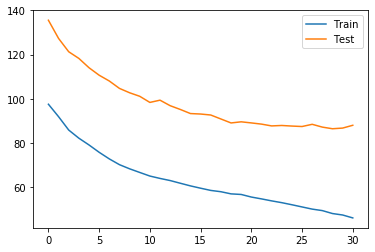

In [65]:
#plotting our train and test MSE with respect to the number of epochs.
plt.plot(history.history['mean_squared_error'], label='Train')
plt.plot(history.history['val_mean_squared_error'], label='Test')
plt.legend()

In [66]:
#generating our predictions
preds = model.predict(test_sequences)

In [67]:
preds.shape

(661, 1)

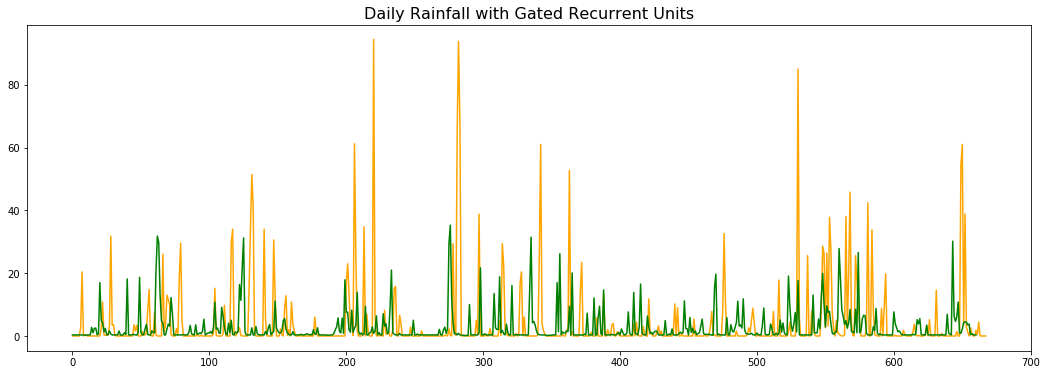

In [68]:
#plotting our predictions against the actual values
plt.figure(figsize=(18,6))
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Daily Rainfall with Gated Recurrent Units', fontsize=16)
plt.show();

Since TimeseriesGenerator was utilized, our predictions is now in an array format.  
As such we will have to unpack the data, assign it to the correct dates and plot it out together with our train and test target values.

In [69]:
length = (len(sydney) - len(preds))

In [70]:
training = sydney[:length]

In [71]:
testing = sydney[length:]

In [72]:
testing.index[0]

Timestamp('2015-05-31 00:00:00', freq='D')

In [73]:
type(preds)

numpy.ndarray

In [74]:
#creating a dataframe from our predicitons which was in array format
predictions = pd.DataFrame(preds, columns=['preds'])

In [75]:
# Reset index to match the date range of our test dataset
predictions.index = pd.date_range(start = '05/31/2015',
                                periods = len(predictions),
                                freq = 'D')

# Print shape of dataframe.
print(predictions.shape)

# Check head of dataframe.
predictions.head()

(661, 1)


preds
2015-05-31  0.333771
2015-06-01  0.318342
2015-06-02  0.333771
2015-06-03  0.333771
2015-06-04  0.333771

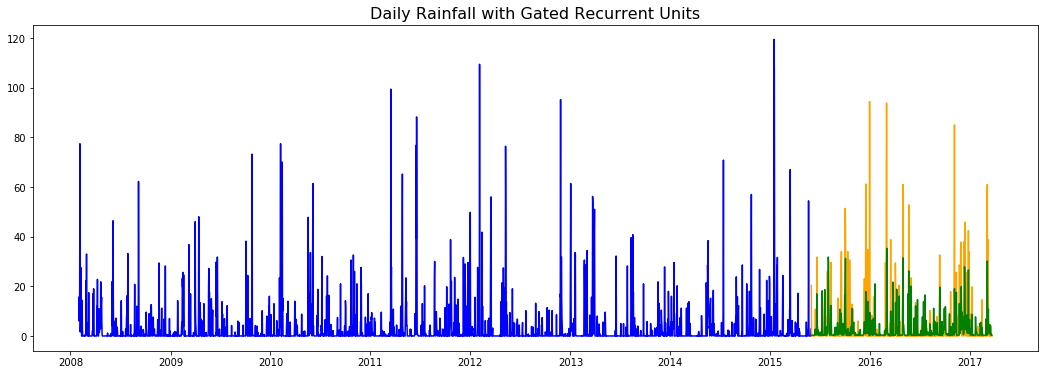

In [78]:
#plotting our final comparison between our actual and model predictions.
plt.figure(figsize=(18,6))
plt.plot(training['Rainfall'], color = 'blue')
plt.plot(testing['Rainfall'], color = 'orange')
plt.plot(predictions, color = 'green')
plt.title(label = 'Daily Rainfall with Gated Recurrent Units', fontsize=16)
#plt.savefig('./images/GRU.png', bbox_inches='tight')
plt.show();

In [77]:
GRU_mse = mean_squared_error(testing['Rainfall'],predictions)
GRU_mse

87.995846130036

# Conclusions and Recommendations

### In Summary:  

Our MSE values for our various models are as follows:

Baseline: **125.6**


SARIMAX: **99.1**


Prophet: **104.2**


GRU: **87.9**



GRU being the best regression estimator for Daily Rainfall.


All our models performed fairly similar with GRU marginally taking the position as best regressor for the prediciton of daily rainfall and as such is our model of choice. However, all of the models were unable to reproduce the large spikes in our test data but managed to capture the increasing/decraesing trends in the days themselves.

There are quite a few caveats for the models above.  
Our SARIMAX model, though it did perform just a little worse than our GRU had a a limitation on seasonality. Here our seasonalities are assumed to recur within a period of less than a year. Yearly seasonalities are unable to be incorporated within our model as it would be assumed to be non seasonal. The seasonality had to be inferred by using a statsmodel decompose and manually imputed in our SARIMAX.  
This limitations is able to be overcome by fb's Prophet and GRU.

fb's prophet infers the seasonality from the data and is able to decompose and present to us the seasonalities and trends of data in different granularities. However both the SARIMAX and and Prophet predicted negative values in its regression models. Obviously in the case of Rainfall, there is no such thing as negative Rainfall and as such requires the conversion of these negative values to 0.  
This didnt seem to be a problem with our GRU.

GRU is a neural network called Gated Recurrent Units. Unlike normal neural networks, it's able to incorporate the time factor by introducing 'memory' to the model. With the interconnection of features and nodes, the correlations and relationships with the production of the target variable is more complex and complete in a sense. It covers aspects that we are unable to impute manually in our usual machine learning methods which are based on prior analyses. As such, even prior to its perusal, it was expected to perform the best out of our options and it did manage to deliver. Even so, despite its complexity, it did not do as well as predicted. This could be attributed to the complexity of weather in itself. The above features may and could have been insufficient factors to accurately predict Rainfall amounts.  

Looking ahead, ways to improve our model would be to incorporate more factors that could influence the Rainfall, such as Wind Speed, which we had to drop due to insufficient data. Also more spatial factors like the weather patterns in other areas/countries may influence our predictions. In other words, the weather situation of a region in close proximity a few days ago may significantly influence our weather today, as opposed to simply our weather itself a few days ago. Even unforseen phenomena such as volcanic eruptions, earthquakes and typhoons in other countries may largely affect not just single predictions but possibly over a period of time as well.



In conclusion, GRU is our model of choice as it has the best MSE score and can be utilised by the DPIE of NSW to predict daily rainfall in Sydney. However, the DPIE should incorporate and consider more factors to further improve this model and possibly utilise it in other regions of the state.